# Slightly compressible flow
In this tutorial we investigate how to use **PorePy** to solve slighlty compresible flow. <br>


**Note**: This tutorial will focus on a 2d domain, however most of the code works for 1d, 2d, and 3d domains.<br>

Let is $\Omega$ a regular domain with boundary $\partial \Omega$. The boundary can be divided in two non-overlapping parts useful to impose Dirichlet ($\partial \Omega_d$) and Neumann ($\partial \Omega_n$) boundary conditions. We indicate with $\mathbf{n}$ the outward unit normal vector of $\partial \Omega$.<br>
The single-phase flow can be written in primal formulation as:

$$ \phi\frac{\partial\rho}{\partial t}- \nabla \cdot \rho K \nabla p = \rho f $$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad - K \nabla p \cdot \mathbf{n} = u_b$$

Where $\phi$ is the porosity, $\rho$ is the fluid density, $f$ is a scalar source/sink term, $K$ is the permeability matrix, $p_b$ is the pressure at the boundary (Dirichlet condition), and $u_p$ is the flux at the boundary (Neumann condition).<br>

As a relationship between pressure and density we use $c_p\rho = \text{d}\rho/\text{d}p$. Assuming slightly compressible flow (e.g., $\nabla\rho\cdot K\nabla p \ll 1$) we can write conservation of mass as

$$c_p\phi\frac{\partial p}{\partial t} - \nabla \cdot K \nabla p = f $$

We now discretize in time using backward Euler and time step $k$:
$$c_p\phi\frac{p^{k+1} - p^k}{k} - \nabla \cdot K \nabla p^{k+1} = f^{k+1} $$


# Import modules

First we have to import the modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from porepy.numerics.compressible.problems import SlightlyCompressible

from porepy.grids import structured
from porepy.viz import plot_grid

# Define problem:
We define our problem in the unit square. We let our problem inherit from the compressible problem base class to set default values.

In [2]:
class UnitSquareInjection(SlightlyCompressible):

    def __init__(self):
        nx = 11
        ny = 11

        physdims = [1, 1]

        g = structured.CartGrid([nx, ny], physdims=physdims)
        g.compute_geometry()
        self.g = g
        # Initialize base class
        SlightlyCompressible.__init__(self)

    #--------grid function--------
    
    def grid(self):
        return self.g

    #--------Inn/outflow terms---------------

    def source(self, t):
        f = np.zeros(self.g.num_cells)
        source_cell = round(self.g.num_cells / 2)
        f[source_cell] = 20*self.g.cell_volumes[source_cell]  # m**3/s
        return f * (t < .05)

    #--------Parameters------------
    
    def porosity(self):
        return  np.ones(self.g.num_cells)
    
    #--------Time stepping------------
    def time_step(self):
        return .001

    def end_time(self):
        return 0.1


We can now initialize the problem and solve

In [3]:
problem = UnitSquareInjection()
problem.solve()
pressures = problem.data['pressure']


And we plot the solution

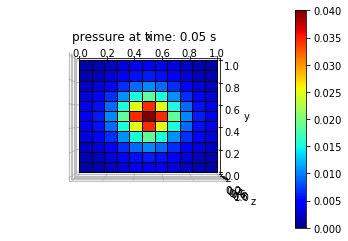

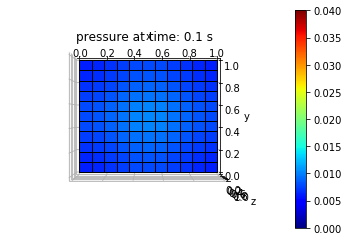

In [4]:
time_steps = [50,100]
dt = problem.time_step()

for t in time_steps:
    p = pressures[t]
    plot_grid.plot_grid(problem.g, p, color_map = [0, 0.04], if_plot=False)
    plt.title('pressure at time: %g s' %(t*dt))
    plt.show()


# Compressible flow with fractures

For a fractured domain we need to import some new classes:

In [5]:
from porepy.numerics.compressible.problems import SlightlyCompressibleMultiDim, SubProblem
from porepy.fracs import meshing
from porepy.params import tensor


We create two different types of problems, one for the fractures, and one for the matrix. For the fractures we use all the standard parameters, but we set the apperture to 0.01. We also define a source term in the intersection of the two fractures

In [6]:
class MatrixDomain(SubProblem):
    def __init__(self, g):
        SubProblem.__init__(self, g)

class FractureDomain(SubProblem):
    def __init__(self, g):
        SubProblem.__init__(self, g)
        aperture = np.power(0.001, 2 - g.dim)
        self.data()['param'].set_aperture(aperture)
        
    def permeability(self):
        kxx = 1000 * np.ones(self.g.num_cells)
        return tensor.SecondOrder(2, kxx)

class IntersectionDomain(FractureDomain):
    def __init__(self, g):
        FractureDomain.__init__(self, g)

    def source(self, t):
        assert self.g.num_cells == 1, '0D grid should only have 1 cell'
        f = .4 * self.g.cell_volumes  # m**3/s
        return f * (t < .05)

We can now create the global problem, which inherits from the SlightlyCompressibleMultiDim class. The important thing to notice with this classs is the set_sub_problem() function. Here we define a problem for each of the grids in the GridBucket, which is stored in the data with the keyword 'problem'

In [7]:
class UnitSquareInjection(SlightlyCompressibleMultiDim):

    def __init__(self):
        nx = 12
        ny = 12
        frac1 = np.array([[0, 1], [.5, .5]])
        frac2 = np.array([[.5, .5], [0, 1]])
        fracs = [frac1, frac2]
        physdims = [1, 1]
        g = meshing.cart_grid(fracs, [nx, ny], physdims=physdims)
        g.assign_node_ordering()
        g.compute_geometry()
        self.g = g
        # Initialize base class
        SlightlyCompressibleMultiDim.__init__(self)

    #--------grid function--------

    def grid(self):
        return self.g

    def set_sub_problems(self):
        self.grid().add_node_props(['problem'])
        for g, d in self.grid():
            if g.dim == 2:
                d['problem'] = MatrixDomain(g)
            elif g.dim == 1:
                d['problem'] = FractureDomain(g)
            elif g.dim == 0:
                d['problem'] = IntersectionDomain(g)
            else:
                raise ValueError('Unkown grid-dimension %d' %g.dim)
    #--------Time stepping------------
    def time_step(self):
        return .001

    def end_time(self):
        return 0.1

We now initialize the problem and solve it:

In [8]:
problem = UnitSquareInjection()
solution = problem.solve()

And we can plot the result

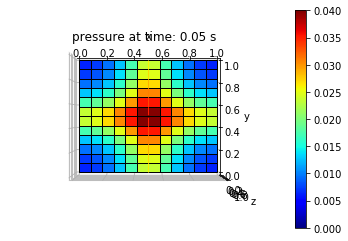

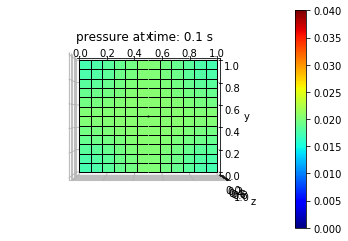

In [9]:
pressures = solution['pressure']
time_steps = [50,100]
dt = problem.time_step()

for t in time_steps:
    p = pressures[t]
    problem.time_disc().split(problem.grid(), 'pressure', p)
    plot_grid.plot_grid(problem.g, 'pressure', color_map = [0, 0.04], if_plot=False)
    plt.title('pressure at time: %g s' %(t*dt))
    plt.show()